In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import vgg16

/var/folders/hg/69dt6nq563b9pt0myh8sprb40000gn/T/ipykernel_8720/3587683207.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-14 15:11:02.242354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/SAGOR/Labs/AI_Lab/ai_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' m

# For GPU users

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(f'GPU: {physical_devices}')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

GPU: []


# Dataset from google drive

In [3]:
# from google.colab import drive

# drive.mount('/content/drive/')
# data_folder_path = '/content/drive/MyDrive/'

# Dataset create

In [4]:
import os
import cv2

train_cutter_dir = './data/train/cutter/'
train_rubber_dir = './data/train/rubber/'
test_cutter_dir = './data/test/cutter/'
test_rubber_dir = './data/test/rubber/'
val_cutter_dir = './data/val/cutter/'
val_rubber_dir = './data/val/rubber/'


def load_images(directory):
    images = []
    labels = []
    idx = 1
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            print(f"\rimage no: {idx}", end='')
            idx = idx + 1
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.resize(img, (32, 32))
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
            if 'cutter' in directory:
                labels.append(0)
            elif 'rubber' in directory:
                labels.append(1)
    return np.array(images), np.array(labels)


print("Loading train images...")
train_cutter_images, train_cutter_labels = load_images(train_cutter_dir)
print()
train_rubber_images, train_rubber_labels = load_images(train_rubber_dir)
print("\nLoading test images...")
test_cutter_images, test_cutter_labels = load_images(test_cutter_dir)
print()
test_rubber_images, test_rubber_labels = load_images(test_rubber_dir)
print("\nLoading validation images...")
val_cutter_images, val_cutter_labels = load_images(val_cutter_dir)
print()
val_rubber_images, val_rubber_labels = load_images(val_rubber_dir)

train_images = np.concatenate((train_cutter_images, train_rubber_images))
train_labels = np.concatenate((train_cutter_labels, train_rubber_labels))
test_images = np.concatenate((test_cutter_images, test_rubber_images))
test_labels = np.concatenate((test_cutter_labels, test_rubber_labels))
val_images = np.concatenate((val_cutter_images, val_rubber_images))
val_labels = np.concatenate((val_cutter_labels, val_rubber_labels))

train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

print(f'\nShape of train_images: {train_images.shape}')
print(f'Shape of train_labels: {train_labels.shape}')
print(f'Shape of test_images: {test_images.shape}')
print(f'Shape of test_labels: {test_labels.shape}')
print(f'Shape of val_images: {val_images.shape}')
print(f'Shape of val_labels: {val_labels.shape}')

Loading train images...
image no: 40

Invalid SOS parameters for sequential JPEG


image no: 81

Invalid SOS parameters for sequential JPEG


image no: 381
image no: 270

Invalid SOS parameters for sequential JPEG


image no: 326
Loading test images...
image no: 45
image no: 43

Invalid SOS parameters for sequential JPEG


image no: 47
Loading validation images...
image no: 49
image no: 13

Invalid SOS parameters for sequential JPEG


image no: 44
Shape of train_images: (707, 32, 32, 3)
Shape of train_labels: (707,)
Shape of test_images: (92, 32, 32, 3)
Shape of test_labels: (92,)
Shape of val_images: (93, 32, 32, 3)
Shape of val_labels: (93,)


In [5]:
random_indices = np.random.permutation(len(train_images))
train_images = train_images[random_indices]
train_labels = train_labels[random_indices]
random_indices = np.random.permutation(len(val_images))
val_images = val_images[random_indices]
val_labels = val_labels[random_indices]
random_indices = np.random.permutation(len(test_images))
test_images = test_images[random_indices]
test_labels = test_labels[random_indices]

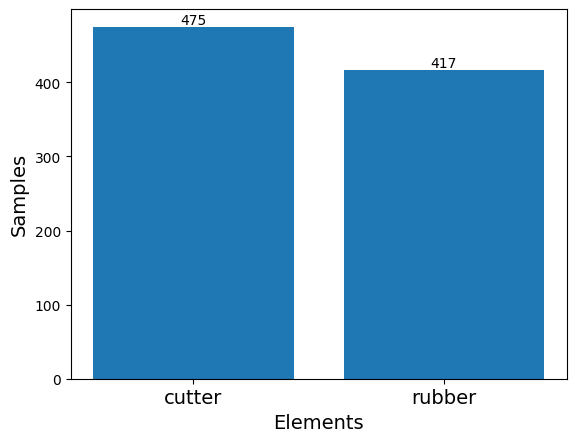

In [6]:

labels = np.concatenate((train_labels, test_labels, val_labels))

values, counts = np.unique(labels, return_counts=True)

plt.bar(values, counts)
plt.xlabel('Elements', fontsize=14)
plt.ylabel('Samples', fontsize=14)
# plt.title('Number of Samples', fontsize=14)

for i, count in enumerate(counts):
    plt.text(values[i], count, str(count), ha='center', va='bottom')

plt.xticks(values, ['cutter', 'rubber'], fontsize=14)

# plt.savefig('total_samples.png')

plt.show()


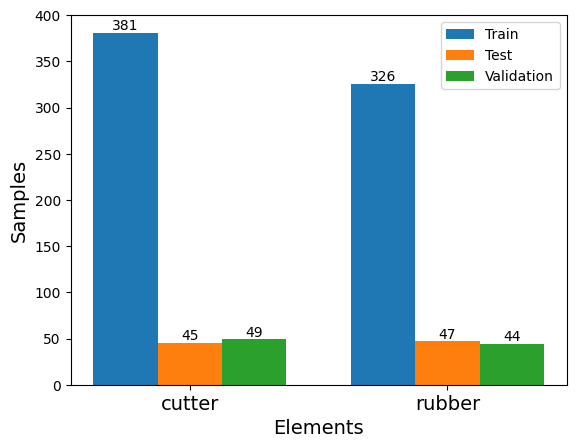

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Calculate counts for each label in train, test, and val sets
train_values, train_counts = np.unique(train_labels, return_counts=True)
test_values, test_counts = np.unique(test_labels, return_counts=True)
val_values, val_counts = np.unique(val_labels, return_counts=True)

bar_width = 0.25

# Set the x positions for the train, test, and val bars
train_x = np.arange(len(train_values)) - bar_width
test_x = np.arange(len(test_values))
val_x = np.arange(len(val_values)) + bar_width

# plt.figure(figsize=(10, 6))

# Plot the train bars and their counts
plt.bar(train_x, train_counts, width=bar_width, label='Train')
for i, count in enumerate(train_counts):
    plt.text(train_x[i], count, str(count), ha='center', va='bottom')

# Plot the test bars and their counts
plt.bar(test_x, test_counts, width=bar_width, label='Test')
for i, count in enumerate(test_counts):
    plt.text(test_x[i], count, str(count), ha='center', va='bottom')

# Plot the val bars and their counts
plt.bar(val_x, val_counts, width=bar_width, label='Validation')
for i, count in enumerate(val_counts):
    plt.text(val_x[i], count, str(count), ha='center', va='bottom')



plt.xlabel('Elements', fontsize=14)
plt.ylabel('Samples', fontsize=14)
# plt.title('Number of Samples', fontsize=14)

# Set x-axis ticks and labels
plt.xticks(test_x, ['cutter', 'rubber'], fontsize=14)

# Add legend
plt.legend()

# Save the plot
# plt.savefig('spillited_samples.png')

# Show the plot
plt.show()


Label: cutter


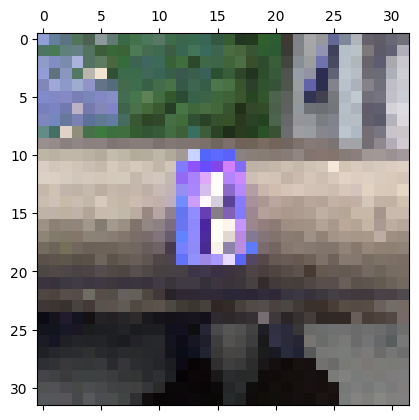

In [8]:
idx = 20
print("Label:", 'cutter' if labels[idx]==0 else 'rubber')
plt.matshow(train_images[idx])

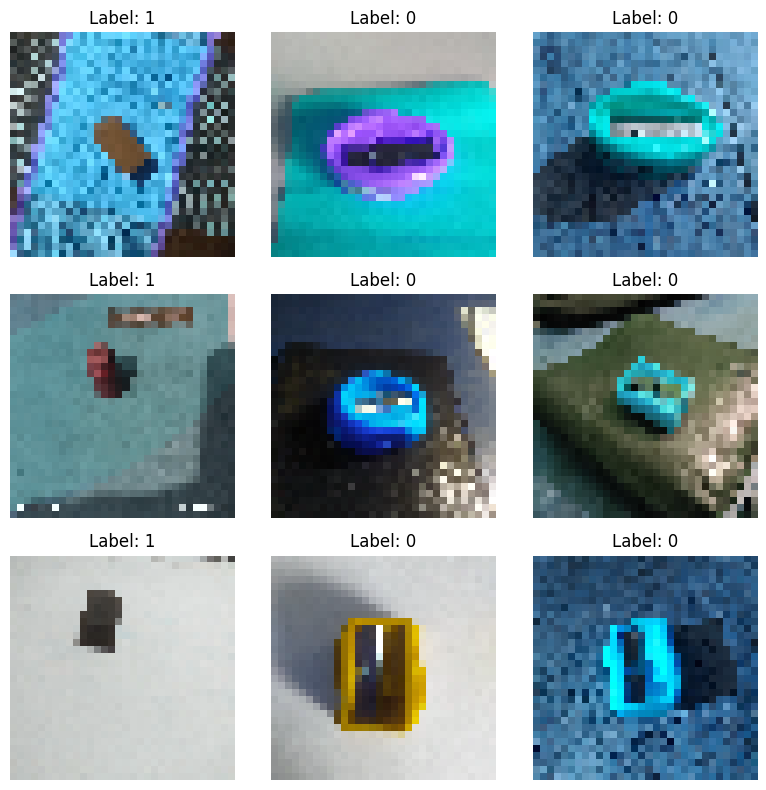

In [9]:
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

axes = axes.flatten()

for i in range(num_rows * num_cols):
    axes[i].imshow(train_images[i]) 
    axes[i].axis('off')
    axes[i].set_title(f'Label: {train_labels[i]}', fontsize=12)

plt.tight_layout()

# plt.savefig('sample_images.png')
plt.show()


# CNN Model

In [37]:
model = Sequential([
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding='same'),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding='same'),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size = (3,3), activation = 'relu', padding='same'),
    Conv2D(filters=128, kernel_size = (3,3), activation = 'relu', padding='same'),
    Conv2D(filters=128, kernel_size = (3,3), activation = 'relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

model.build(input_shape=(None, 32, 32, 3))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       147584    
                                                      

In [11]:
# vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# for layer in vgg16_model.layers[:-2]:
#     layer.trainable = False

# vgg16_model.summary(show_trainable=True)

# model = Sequential([
#     vgg16_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(512, activation='relu'),
#     Dense(2, activation='softmax')
# ])

# # model.build(input_shape=(None, 32, 32, 3))
# model.summary(show_trainable=True)

In [38]:
from tensorflow import keras

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    './model/',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

def scheduler(epoch, lr):
    if epoch < 7:
        return lr
    else:
       return lr * np.exp(-0.1)
    
learning_rate_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [39]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=40, callbacks=[early_stop, model_checkpoint, learning_rate_scheduler])


Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.5403INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


23/23 [==============================] - 15s 551ms/step - loss: 0.7120 - accuracy: 0.5403 - val_loss: 0.6296 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - 11s 457ms/step - loss: 0.5899 - accuracy: 0.6775 - val_loss: 1.0116 - val_accuracy: 0.6237 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - 10s 444ms/step - loss: 0.4956 - accuracy: 0.7511 - val_loss: 0.6643 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 4/40
23/23 [==============================] - 19s 846ms/step - loss: 0.5789 - accuracy: 0.7341 - val_loss: 0.8274 - val_accuracy: 0.5376 - lr: 0.0010
Epoch 5/40
23/23 [==============================] - 13s 570ms/step - loss: 0.5581 - accuracy: 0.6775 - val_loss: 0.8786 - val_accuracy: 0.6022 - lr: 0.0010
Epoch 6/40
23/23 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.7313INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


23/23 [==============================] - 21s 945ms/step - loss: 0.5290 - accuracy: 0.7313 - val_loss: 0.6131 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 7/40
23/23 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8373INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


23/23 [==============================] - 21s 938ms/step - loss: 0.3751 - accuracy: 0.8373 - val_loss: 0.5189 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 8/40
23/23 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8911INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


23/23 [==============================] - 14s 595ms/step - loss: 0.2803 - accuracy: 0.8911 - val_loss: 0.3883 - val_accuracy: 0.8172 - lr: 9.0484e-04
Epoch 9/40
23/23 [==============================] - 12s 542ms/step - loss: 0.2015 - accuracy: 0.9137 - val_loss: 0.9310 - val_accuracy: 0.7634 - lr: 8.1873e-04
Epoch 10/40
23/23 [==============================] - 12s 528ms/step - loss: 0.2483 - accuracy: 0.9222 - val_loss: 0.7909 - val_accuracy: 0.7312 - lr: 7.4082e-04
Epoch 11/40
23/23 [==============================] - 11s 490ms/step - loss: 0.1746 - accuracy: 0.9406 - val_loss: 0.8614 - val_accuracy: 0.8387 - lr: 6.7032e-04
Epoch 12/40
23/23 [==============================] - 18s 775ms/step - loss: 0.2575 - accuracy: 0.9165 - val_loss: 0.4507 - val_accuracy: 0.8065 - lr: 6.0653e-04
Epoch 13/40
23/23 [==============================] - 17s 764ms/step - loss: 0.1522 - accuracy: 0.9533 - val_loss: 0.6535 - val_accuracy: 0.7849 - lr: 5.4881e-04
Epoch 14/40
23/23 [============================

# Model history view

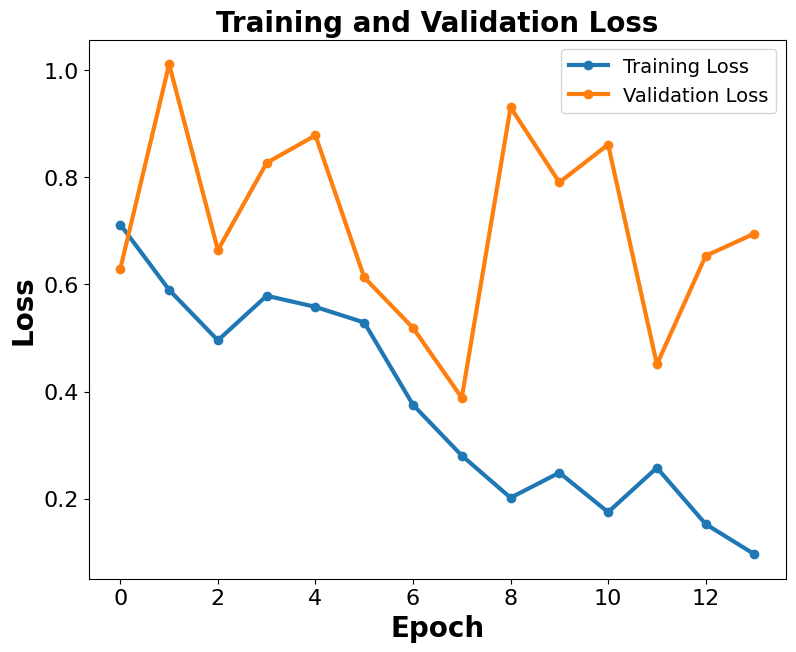

In [47]:

new_folder_path = os.path.join(f'Learning_rate_{learning_rate}')

os.makedirs(new_folder_path, exist_ok=True)

plt.figure(figsize=(9, 7))

plt.plot(history.history['loss'],  '-o',  label='Training Loss', linewidth=3)
plt.plot(history.history['val_loss'], '-o', label='Validation Loss', linewidth=3)
plt.xlabel('Epoch',fontsize=20, fontweight='bold')
plt.ylabel('Loss', fontsize=20,fontweight='bold')
plt.title('Training and Validation Loss', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)

plt.savefig(f'./Learning_rate_{learning_rate}/CNN_Training_and_Validation_Loss_{learning_rate}.png')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], '-o', linewidth=2)
plt.plot(history.history['val_accuracy'], '-o', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig('TR_Training_and_Validation_Accuracy1.png')
plt.show()

# Testing

In [45]:
model = keras.models.load_model('./model/')

val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f"Val Loss: {val_loss :.4f}")
print(f"Val Accuracy: {val_accuracy*100 :.2f}%")

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss :.4f}")
print(f"Test Accuracy: {test_accuracy*100 :.2f}%")

3/3 [==============================] - 1s 176ms/step - loss: 0.3883 - accuracy: 0.8172
Val Loss: 0.3883
Val Accuracy: 81.72%
3/3 [==============================] - 0s 110ms/step - loss: 0.4398 - accuracy: 0.8152
Test Loss: 0.4398
Test Accuracy: 81.52%


In [ ]:
y_pred = model.predict(test_images)
y_pred_labels = [np.argmax(i) for i in y_pred]
y_pred[0]

In [ ]:
idx = 30
print(f'Actual: {"cutter" if np.argmax(y_pred[idx]) == 0 else "rubber"}')
plt.matshow(test_images[idx])

In [ ]:
import seaborn as sn

cm = tf.math.confusion_matrix(labels=test_labels, predictions=y_pred_labels)

heatmap = sn.heatmap(cm, annot=True, fmt='d')

heatmap.set_xlabel('Predicted', fontsize=14)
heatmap.set_ylabel('Truth', fontsize=14)
heatmap.set_xticklabels(['cutter', 'rubber'], ha='center', fontsize=14)
heatmap.set_yticklabels(['cutter', 'rubber'], va='center', fontsize=14)

plt.text(1, -0.2, f'Test Accuracy: {test_accuracy*100 :.2f}%', horizontalalignment='center', verticalalignment='center', fontsize=14)


# plt.savefig('TR_confusion_matrix1.png')
plt.show()